In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [52]:
data = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [53]:
data.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'selling_price'}>],
       [<Axes: title={'center': 'km_driven'}>, <Axes: >]], dtype=object)

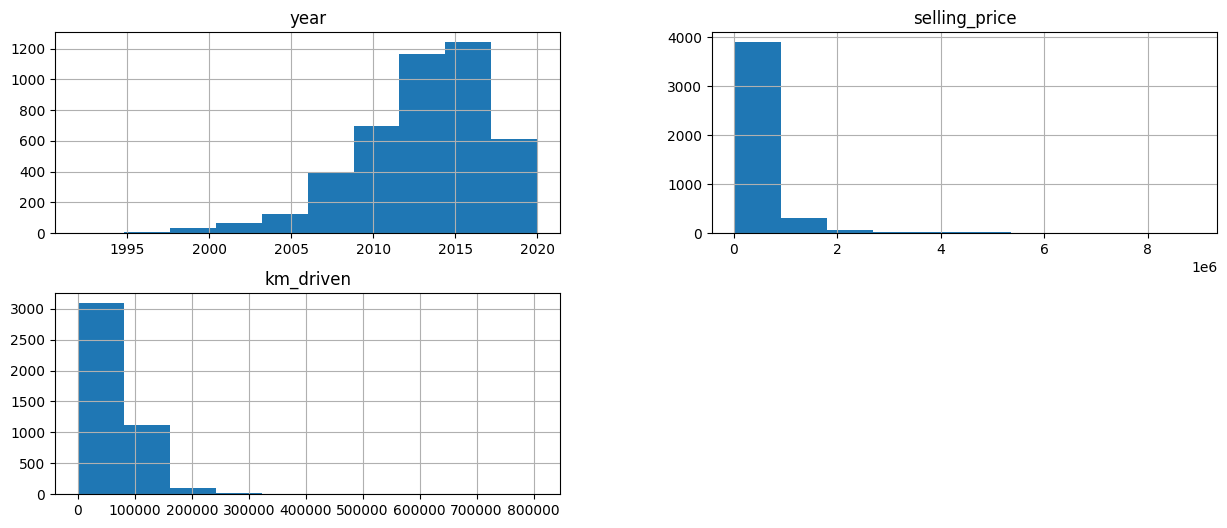

In [55]:
data.hist(figsize=(15,6))

In [56]:
data_new = data.drop(['name'], axis=1)

In [57]:
#Категориальные признаки
df_categorical_features = data_new.select_dtypes(include=[object])

df_categorical_features.columns

Index(['fuel', 'seller_type', 'transmission', 'owner'], dtype='object')

In [58]:
#Числовые признаки
df_numeric_features = data_new.select_dtypes(include=[np.number])

df_numeric_features.columns

Index(['year', 'selling_price', 'km_driven'], dtype='object')

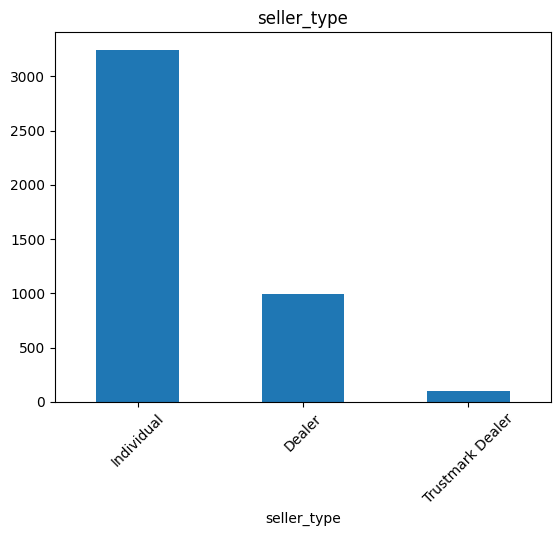

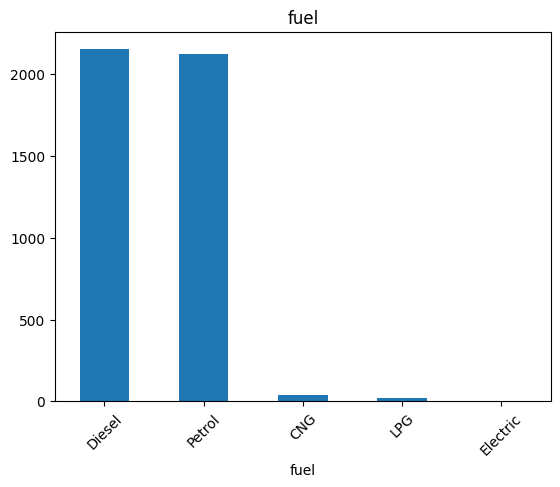

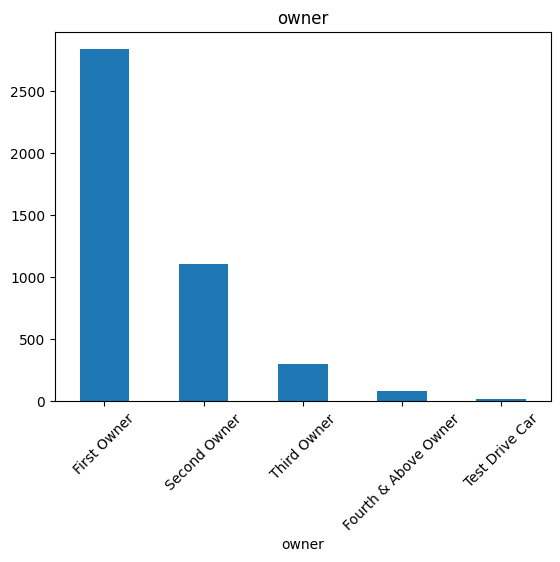

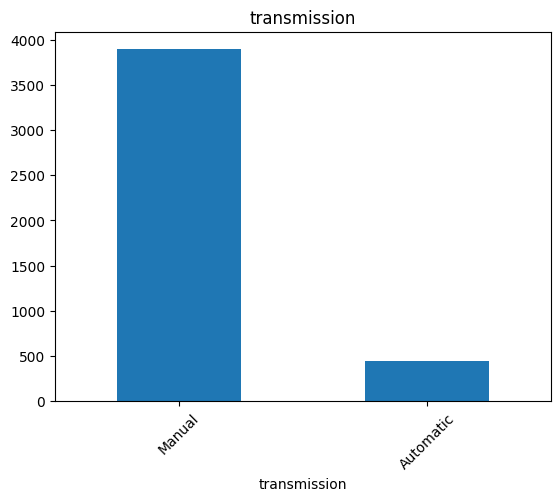

In [59]:
#Диаграмма распределенности типов продавцов
seller_type = ["seller_type"]
fig, ax = plt.subplots(1, len(seller_type))
for i, seller_type in enumerate(data_new[seller_type]):
    data_new[seller_type].value_counts().plot(kind="bar").set_title(seller_type)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов топлива
fuel = ["fuel"]
fig, ax = plt.subplots(1, len(fuel))
for i, fuel in enumerate(data_new[fuel]):
    data_new[fuel].value_counts().plot(kind="bar").set_title(fuel)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов владельцев
owner = ["owner"]
fig, ax = plt.subplots(1, len(owner))
for i, owner in enumerate(data_new[owner]):
    data_new[owner].value_counts().plot(kind="bar").set_title(owner)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

#Диаграмма распределенности типов трансмиссии
transmission = ["transmission"]
fig, ax = plt.subplots(1, len(transmission))
for i, transmission in enumerate(data_new[transmission]):
    data_new[transmission].value_counts().plot(kind="bar").set_title(transmission)
plt.xticks(rotation=45)
#plt.yticks(np.arange(0, 45000, 3000.0))
plt.show()

In [60]:
from sklearn.compose import ColumnTransformer

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

In [61]:
target = data_new['selling_price']
features = data_new.drop(['selling_price'], axis=1)
features["fuel"] = features["fuel"].astype("category")
features["seller_type"] = features["seller_type"].astype("category")
features["transmission"] = features["transmission"].astype("category")
features["owner"] = features["owner"].astype("category")

In [62]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          4340 non-null   int64   
 1   km_driven     4340 non-null   int64   
 2   fuel          4340 non-null   category
 3   seller_type   4340 non-null   category
 4   transmission  4340 non-null   category
 5   owner         4340 non-null   category
dtypes: category(4), int64(2)
memory usage: 85.6 KB


In [63]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=44)

In [64]:
simple_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
pca = PCA(n_components=1)
pipe_num = Pipeline([('imputer', simple_imputer), ('scaler', std_scaler), ('pca', pca) ])

In [65]:
s_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
#cat_proc = features[['fuel', 'seller_type', 'transmission', 'owner']].astype("category")
pipe_cat = Pipeline([('imputer', s_imputer)])

In [66]:
col_transformer = ColumnTransformer([('num_preproc', pipe_num, [x for x in features.columns if features[x].dtype!='category']),
                                     ('cat_preproc', pipe_cat, [x for x in features.columns if features[x].dtype=='category'])])

In [67]:
res = col_transformer.fit_transform(features_train)
res_df = pd.DataFrame(res, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
res_df

,pca0,fuel,seller_type,transmission,owner
0,-1.664826,Petrol,Dealer,Manual,First Owner
1,1.414677,Petrol,Individual,Manual,Second Owner
2,0.980985,Diesel,Individual,Manual,Second Owner
3,-0.040964,Petrol,Individual,Manual,Second Owner
4,-0.212599,Diesel,Individual,Manual,First Owner
...,...,...,...,...,...
3467,0.717245,Diesel,Dealer,Manual,First Owner
3468,-0.957615,Diesel,Dealer,Manual,Second Owner
3469,-1.496605,Petrol,Individual,Manual,First Owner
3470,-1.81817,Petrol,Individual,Manual,First Owner


In [68]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pca0          3472 non-null   object
 1   fuel          3472 non-null   object
 2   seller_type   3472 non-null   object
 3   transmission  3472 non-null   object
 4   owner         3472 non-null   object
dtypes: object(5)
memory usage: 135.8+ KB


In [73]:
cat_features = list([1,2,3,4])
print(cat_features)

[1, 2, 3, 4]


In [74]:
res_df["pca0"] = res_df["pca0"].astype("float64")
res_df["fuel"] = res_df["fuel"].astype("category")
res_df["seller_type"] = res_df["seller_type"].astype("category")
res_df["transmission"] = res_df["transmission"].astype("category")
res_df["owner"] = res_df["owner"].astype("category")

In [87]:
model_1 = CatBoostRegressor(cat_features=cat_features, n_estimators=400)

final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model_1)])

In [88]:
final_pipe.fit(features_train, target_train)
preds = final_pipe.predict(features_test)

Learning rate set to 0.104982
0:	learn: 549923.7294175	total: 64.8ms	remaining: 25.8s
1:	learn: 521903.3925118	total: 109ms	remaining: 21.7s
2:	learn: 498782.3813248	total: 146ms	remaining: 19.3s
3:	learn: 478039.8596525	total: 185ms	remaining: 18.4s
4:	learn: 462211.3606401	total: 218ms	remaining: 17.2s
5:	learn: 445516.1682794	total: 267ms	remaining: 17.5s
6:	learn: 431295.3283671	total: 307ms	remaining: 17.2s
7:	learn: 419319.4264418	total: 341ms	remaining: 16.7s
8:	learn: 409882.7805396	total: 374ms	remaining: 16.2s
9:	learn: 401487.4112287	total: 409ms	remaining: 16s
10:	learn: 393510.8213203	total: 451ms	remaining: 16s
11:	learn: 386784.1252392	total: 489ms	remaining: 15.8s
12:	learn: 381227.5514913	total: 524ms	remaining: 15.6s
13:	learn: 376259.2386955	total: 558ms	remaining: 15.4s
14:	learn: 372787.1954578	total: 587ms	remaining: 15.1s
15:	learn: 368384.6577737	total: 621ms	remaining: 14.9s
16:	learn: 365140.2808327	total: 656ms	remaining: 14.8s
17:	learn: 361768.4672666	total

In [89]:
mse = mean_squared_error(target_test, preds)
rmse = (np.sqrt(mean_squared_error(target_test, preds)))
mae = mean_absolute_error(target_test, preds)
r2 = r2_score(target_test, preds)
print("Оценка тестового множества модели CatBoost:")
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R2: {:.2f}'.format(r2))

Оценка тестового множества модели CatBoost:
MSE: 81159663270.62
RMSE: 284885.35
MAE: 167770.80
R2: 0.75


In [90]:
print(final_pipe.predict(features_test))

[ 319177.32961368  122922.1862374   406579.69261079  365935.51858857
  353272.92899808  246039.8633151   279018.20201057  446831.41805864
  435714.40308819  348130.45093965  418174.43744172 1016758.08068244
  416554.23897234  323497.18421294  287053.51947626  154463.43031531
  397837.68749862  185137.46065083  138508.18186319  435714.40308819
  761515.54633788  115293.48065574  444904.17732493  145613.34567775
  455387.03095797  375096.92124186  247956.91418474  167938.36258453
  406579.69261079  532489.82534654  142898.51918082  136676.33541795
  407087.02641272  541083.87564546  925962.84775482  368025.79366175
 2082962.41246616  298221.3256668   770464.11775961  188227.75377644
  302732.90440829  368025.79366175  297349.64602923  544174.31775087
  322874.00420399  326942.23299489  908381.0560379   544174.31775087
  416640.90635446   99707.48502995  224060.15437093  136676.33541795
  707295.11150049  443978.62370411  272319.84807783   83521.85199502
  286307.28720599  709012.53740282

In [91]:
target_test

2695     250000
1259      75000
2556     114999
3319     700000
2040     110000
         ...   
2368     650000
1558     500000
3565     500000
3284    1500000
2922     170000
Name: selling_price, Length: 868, dtype: int64

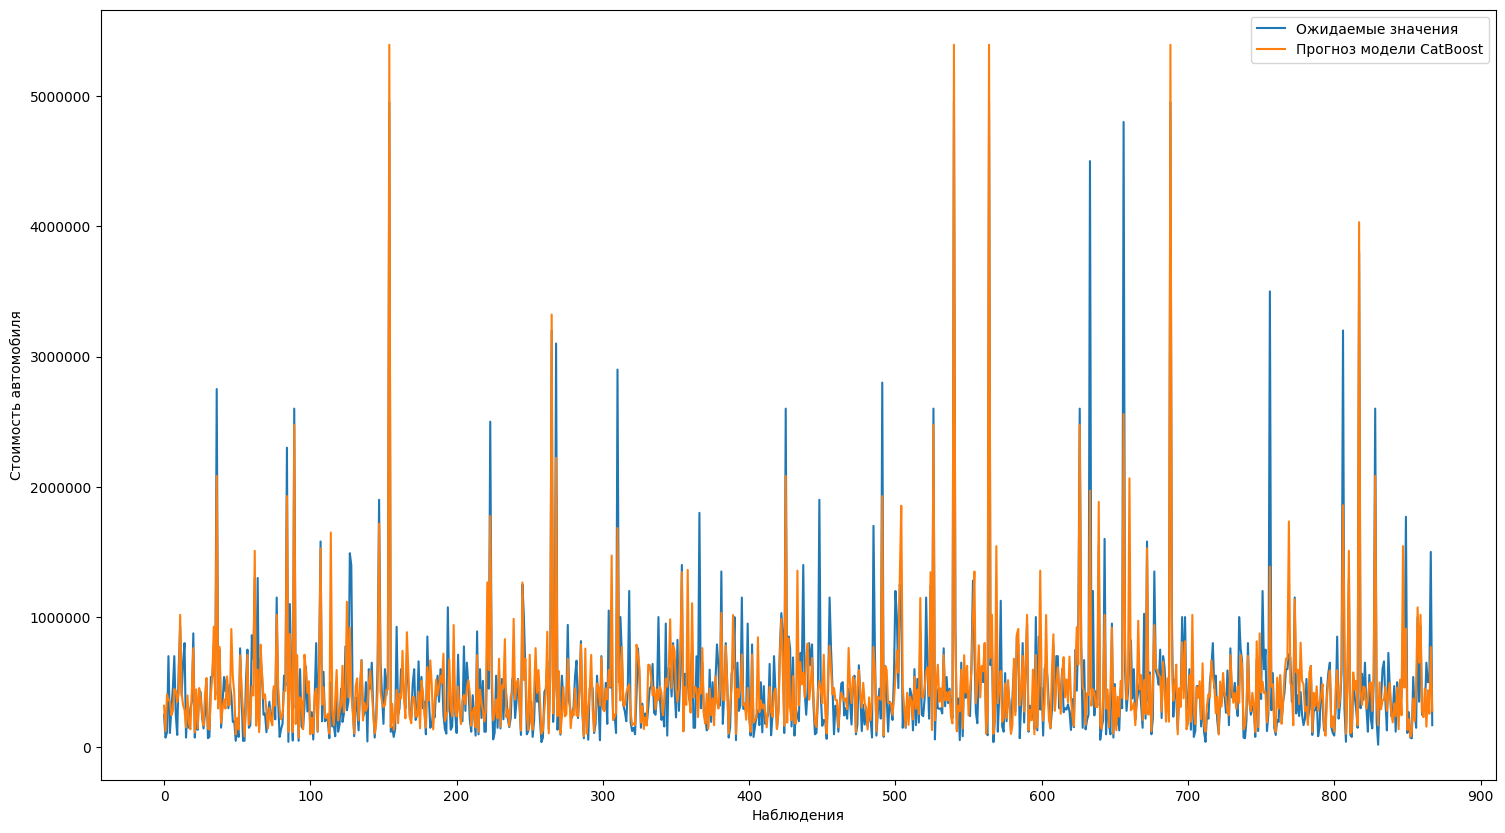

In [92]:
plt.figure(figsize=(18,10))
plt.plot(target_test.values, label = 'Ожидаемые значения')
plt.plot(final_pipe.predict(features_test), label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.legend()

In [93]:
importances = model_1.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=res_df.columns).sort_values()

In [94]:
print(feature_importances)

owner            1.966560
seller_type      6.361046
fuel            22.880377
pca0            30.734512
transmission    38.057505
dtype: float64


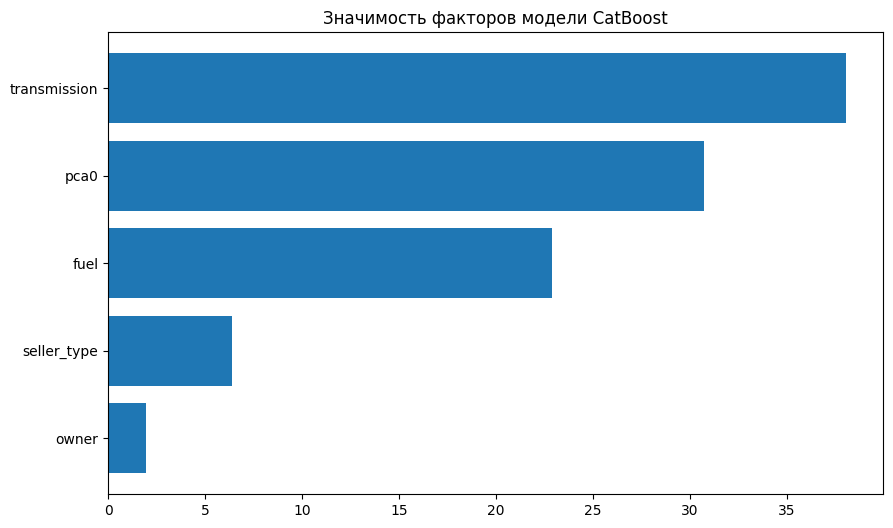

In [95]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()